In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()

#wmt modes
# process_gen_mode="wmt_single"
# process_gen_mode="wmt_samples"
# process_gen_mode="wmt_single"
# process_gen_modes=["wmt_samples0", "wmt_samples1", "wmt_samples2_1","wmt_samples2_2"]

# process_gen_mode="wmt_sample_100"
# process_gen_mode="wmt_sample_50"
    # wmt_sample_100
    
# compare_metric="example_comet"
# compare_metric="BLEU_4"


# process_gen_modes=["gsm_samples1","gsm_samples2","gsm_samples3"]
process_gen_modes=["fairseq_softmax"]



do_norm_analysis=True
processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
compare_metric="BLEU_4"
examples_df, completions_df=get_dfs(processGens)


dfs_by_model={}

for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    dfs_by_model[model_name]=filtered_df

all_dfs_by_model=dfs_by_model
# if(len(models)>1):
    # all_dfs_by_model["all_models"]=examples_df

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode ['fairseq_softmax']
calculate_gen_summary_dict
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Index(['beam_num', 'task_name', 'model', 'example_idx', 'suite', 'instanceID',
       'text', 'completion_length', 'output_logprob', 'isCompletion', 'BLEU_1',
       'BLEU_4'],
      dtype='object')
Num examples: 20000
Num completions: 200


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['fairseq_softmax'] 
 	 custom_metrics['BLEU_1', 'BLEU_4']
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name fairseq 
 	 instance_metrics ['comet']
   beam_num                    task_name            model  example_idx  \
0         1  wmt_14_language_pair_de_en_  fairseq_softmax            0   
1         1  wmt_14_language_pair_de_en_  fairseq_softmax            1   

     suite  instanceID             text  completion_length  \
0  fairseq           0  you need time .                 15   
1  fairseq           0  you need time .                 15   

        output_logprob isCompletion  BLEU_1  BLEU_4  
0  -0.3601841926574707         True     1.0     1.0  
1  -0.3601841926574707         None     1.0     1.0  
num examples 20000
num_completions 200
compare_metric mean:  BLEU_4    0.11675
dtype: float64


Index(['beam_num', 'task_name', 'model', 'example_idx', 'suite', 'instanceID',
       'text', 'completion_length', 'output_logprob', 'isCompletion', 'BLEU_1',
       'BLEU_4'],
      dtype='object')
fairseq_softmax
          output_logprob         BLEU_4
0    -0.3601841926574707   1.000000e+00
1    -0.3601841926574707   1.000000e+00
2    -0.3601842224597931   1.000000e+00
3    -0.3601842224597931   1.000000e+00
4    -0.3601842224597931   1.000000e+00
..                   ...            ...
195   -5.668101787567139  2.225074e-308
196   -6.216953277587891  2.225074e-308
197   -6.941819667816162  1.051050e-308
198   -7.311468124389648  8.185589e-309
199   -8.394006729125977  1.732889e-308

[200 rows x 2 columns]


IndexError: Column(s) ['output_logprob', 'BLEU_4'] already selected

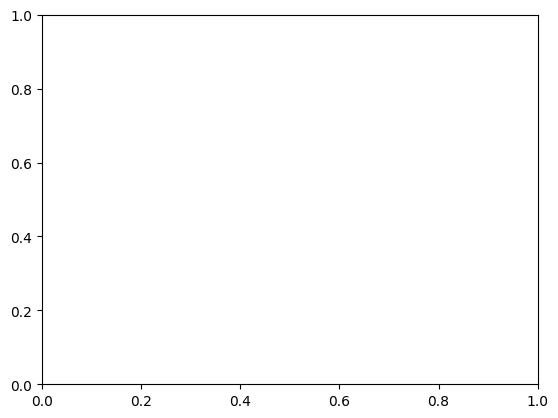

In [22]:

max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None
# fig, axs = plt.subplots(plots_wide, plots_tall, figsize=(8, 8))


def plot_grouped2(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20, error_bar=True):
    if(ax is None):
        _, ax = plt.subplots()
    warnings.simplefilter(action='ignore', category=FutureWarning)
    if(groupby=="bins"):
        df["bins"]=pd.qcut(df[xlabel],nbins)
    
    # agg_vals = ['mean', 'count', 'std'] if error_bar else ['mean']
    grouped = df.groupby(groupby)[[xlabel, ylabel]]
    print(grouped.head(2))
    
    x = grouped[xlabel]
    y = grouped[ylabel]

    ax.scatter(x,y)

    # plt.scatter(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if(title):
        ax.set_title(title)
    ax.show()



for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):

    print(filtered_df.columns)
    print(model_name)    
    if axs is None:
        ax=None
    else:
        title=model_name
        if(num_models>1):
            axs_x=idx % plots_wide
            axs_y= math.floor(idx / plots_wide)
            ax=axs[axs_x, axs_y]
        else:
            ax=axs

    
    def calculate_title():
        return f"{model_name}: {suptitle}" if ax is None else model_name
    # plot by rank within sentence
    suptitle="grouped by rank within sentence"
    # plot_grouped(df=filtered_df, xlabel="output_logprob",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax, error_bar=False)
    plot_grouped2(df=filtered_df, xlabel="output_logprob",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax, error_bar=False)
    plot_spline(df=examples_df, xlabel="output_logprob", ylabel=compare_metric, ax=ax)
    # plot_spline(df=examples_df, xlabel="output_logprob", ylabel=compare_metric, ax=ax)

    
if fig is not None:
    fig.suptitle(title)
    fig.tight_layout()
    

In [4]:
#first: I calculate win rates

def get_iom_metrics_dict(df,compare_metric,ax=None):
    # plot_grouped(df, xlabel, ylabel, groupby='example_idx', title=None, trend_line="None",ax=None, nbins=20):
    # grouped = df.groupby("example_idx")[[xlabel, ylabel]].agg(['mean', 'count', 'std'])

    max_example_idx = df["example_idx"].max()
    num_ranks=max_example_idx+1
    # pivoted = df.pivot(columns='example_idx', values=compare_metric )
    # pivoted_mean=pivoted.mean()
    pivoted = df.pivot(index="instanceID",columns="example_idx", values=compare_metric )
    # print(pivoted.head(2))
    mean_pivoted=pivoted.mean()
    ave_val=mean_pivoted.mean()

    # pivoted_x = df.pivot(columns="example_idx", values="output_logprob").mean()
    
    best_rank = mean_pivoted.idxmax()
    ranks_effected=best_rank
    percent_effected=ranks_effected / num_ranks
    score_diff=0

    win_rate_by_col=[-1]*(best_rank+1)
    for compare_rank in range(best_rank+1):
        win_rate_col_name=f"win_rate_{compare_rank}"
        pivoted[win_rate_col_name] = pivoted.apply( lambda row: get_win_rate(row,compare_rank, best_rank) , axis=1)
        win_rate_by_col[compare_rank] = pivoted[win_rate_col_name].mean()

    win_rate=win_rate_by_col[0]
    # print("win_rate_by_col",win_rate_by_col)

    for compare_rank in range(best_rank):
        score_diff+= mean_pivoted[best_rank]-mean_pivoted[compare_rank]
    

    effect_size=score_diff*percent_effected
    average_diff=score_diff/ranks_effected
    effect_diff=mean_pivoted[best_rank]-mean_pivoted[0]

    average_diff_norm=average_diff/ave_val
    effect_diff_norm=effect_diff/ave_val
    effect_size_norm=effect_size /ave_val

    return {
        # "effect_size": effect_size,
        # "average_diff": average_diff,
        # "effect_diff": effect_diff,
        "percent_effected":percent_effected,
        "win_rate":win_rate,

        "average_diff_norm":average_diff_norm,
        "effect_diff_norm":effect_diff_norm,
        "effect_size_norm":effect_size_norm
    }



iom_metrics_dict_by_model={}
for idx, (model_name, filtered_df) in enumerate(dfs_by_model.items()):
    # print(model_name)
    iom_metrics_dict_by_model[model_name]=get_iom_metrics_dict(filtered_df, compare_metric=compare_metric)
    print(iom_metrics_dict_by_model[model_name])




# 14% effected, 






    


{'percent_effected': np.float64(0.14), 'win_rate': np.float64(0.5205), 'average_diff_norm': np.float64(0.015042813671901004), 'effect_diff_norm': np.float64(0.07155627229668524), 'effect_size_norm': np.float64(0.02948391479692597)}


In [5]:
print(iom_metrics_dict_by_model)

{'meta_llama_Llama_3.1_8B_Instruct': {'percent_effected': np.float64(0.14), 'win_rate': np.float64(0.5205), 'average_diff_norm': np.float64(0.015042813671901004), 'effect_diff_norm': np.float64(0.07155627229668524), 'effect_size_norm': np.float64(0.02948391479692597)}}


In [6]:
#Here is current goal:

#each metric gets a graph
#each suite gets a line
#x axis is model size
#y axis is metric



def append_to_dict(dict, key_list, value):
    cur_key=key_list[0]
    
    #make sure it exists
    if cur_key not in dict.keys():
        dict[cur_key]={}

    #append recursively if not
    if(len(key_list)>1):
        append_to_dict(dict[cur_key], key_list[1:], value)
    else:
        dict[cur_key]=value


iom_metrics_dict_by_properties={}

for (model_name, iom_metrics_dict) in iom_metrics_dict_by_model.items():
    model_details = get_model_details(model_name)

    append_to_dict(iom_metrics_dict_by_properties, [ model_details["suite"], model_details["model_type"],  model_details["size"] ], iom_metrics_dict)

print(iom_metrics_dict_by_properties.keys())



    
print(iom_metrics_dict_by_model)
#plot by model size
# iom_metric_keys=next(iter(iom_metrics_dict_by_model.values())).keys()
# for iom_metric in iom_metric_keys: 
#     fig, ax = plt.subplots()
#     for suite in iom_metrics_dict_by_properties.keys():
#         for model_type in iom_metrics_dict_by_properties[suite].keys():
#             x=[]
#             y=[]
#             for size in iom_metrics_dict_by_properties[suite][model_type].keys():
#                 value=iom_metrics_dict_by_properties[suite][model_type][size][iom_metric]
#                 x.append(size)
#                 y.append(value)
#             ax.scatter(x,y, label=suite)
#     ax.set_xlabel('model size')
#     ax.set_ylabel(iom_metric)
#     ax.legend()
#     fig.show()

#plot by model strength
# for iom_metric in iom_metric_keys: 
#     # print("iom_metric")
#     fig, ax = plt.subplots()
#     x=[]
#     y=[]
#     for (model_name, iom_metrics_dict) in iom_metrics_dict_by_model.items():
#         filtered_df=dfs_by_model[model_name]
#         ave_vale=filtered_df[compare_metric].mean()
#         x.append(ave_vale)
#         y.append(iom_metrics_dict[iom_metric])
#     ax.scatter(x,y)
#     ax.set_xlabel("Average "+str(compare_metric))
#     ax.set_ylabel(iom_metric)
#     ax.legend()
#     #fig.show()





dict_keys(['llama'])
{'meta_llama_Llama_3.1_8B_Instruct': {'percent_effected': np.float64(0.14), 'win_rate': np.float64(0.5205), 'average_diff_norm': np.float64(0.015042813671901004), 'effect_diff_norm': np.float64(0.07155627229668524), 'effect_size_norm': np.float64(0.02948391479692597)}}


213
213
246
246


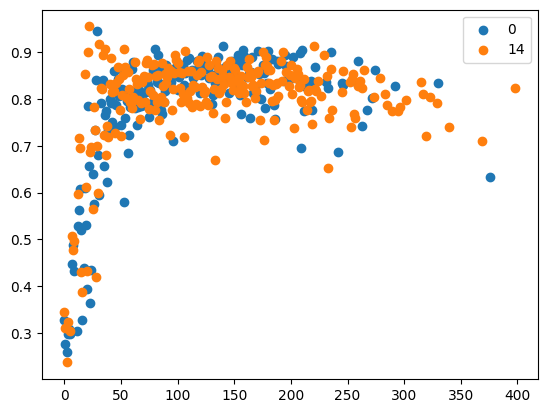

In [7]:
#ok, I only want to keep columns where the rank is 14 or 0
df = filtered_df
max_example_idx = df["example_idx"].max()
num_ranks=max_example_idx+1
pivoted = df.pivot(index="instanceID",columns="example_idx", values=compare_metric )
mean_pivoted=pivoted.mean()
ave_val=mean_pivoted.mean()
best_rank = mean_pivoted.idxmax()

best_and_first=filtered_df[ filtered_df['example_idx'].isin([0, best_rank])]

cols_to_keep=["example_comet", "example_idx", "output_logprob", "completion_length"]
best_and_first=best_and_first[["example_comet", "example_idx", "output_logprob", "completion_length"]]

best_and_first_grouped=best_and_first.groupby(["completion_length", "example_idx"]).mean().reset_index()

_, ax = plt.subplots()


# #we want to see, for each completion length, the average metric score
# #we will do this for both ranks, 0 and 14

for rank in [0, best_rank]:
    cur_df=best_and_first_grouped[best_and_first_grouped["example_idx"]==rank]
    x=cur_df["completion_length"]
    y=cur_df["example_comet"]
    print(len(x))
    print(len(y))
    ax.scatter(x,y, label=rank)
    ax.legend()




In [8]:
filtered_df["logprob_per_length"]=filtered_df["output_logprob"]/ filtered_df["completion_length"]

filtered_df['rank2'] = filtered_df.groupby('instanceID')['logprob_per_length'].rank(method='first', ascending=True) - 1
filtered_df['rank2'] = filtered_df['rank2'].astype(int)



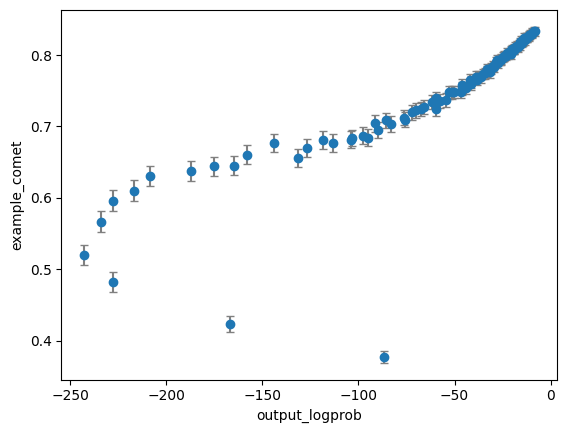

In [9]:
plot_grouped(filtered_df, "output_logprob", compare_metric, groupby='rank2', title=None, trend_line="None",ax=None)

In [12]:
#ok, we just want to predict
#example metric using length and rank

import statsmodels.api as sm
best_and_first["is_completion"]=(best_and_first["example_idx"]==0).astype(int)

X = best_and_first[['completion_length', 'is_completion']]
X = sm.add_constant(X) 
y = best_and_first['example_comet']

model = sm.OLS(y, X).fit()

print(model.summary())

#so, ideally is_completion should be negatively correlated with example_comet


                            OLS Regression Results                            
Dep. Variable:          example_comet   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     189.7
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           3.68e-76
Time:                        16:36:55   Log-Likelihood:                 848.60
No. Observations:                2000   AIC:                            -1691.
Df Residuals:                    1997   BIC:                            -1674.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6936      0.00

In [14]:


X = filtered_df[['completion_length', 'output_logprob']]
X = sm.add_constant(X) 
y = filtered_df['example_comet']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          example_comet   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     7937.
Date:                Thu, 19 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:43:10   Log-Likelihood:                 42406.
No. Observations:              100000   AIC:                        -8.481e+04
Df Residuals:                   99997   BIC:                        -8.478e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7243      0.00